__Author: Rajendra Thapa__
This code takes the HISTORY file from DL-POLY-3 simulations and creates a plot of the MSD for each species. 

In [44]:
import pyprind 
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [45]:
def periodic_distance(atom, nbd, box):
    '''Inputs:
        atom = coordinate of a single reference atom
        nbd = array of coordinates of multiple atoms
        box = length of the box
       Outputs:
        dis = distance between atom and nbd
        len(dis) == len(nbd)
    '''
    delta = np.abs(atom-nbd)
    delta = np.where(delta> 0.5*box, delta-box, delta)
    dis = np.sqrt((delta**2).sum(axis=-1))
    return dis

__Create a function to pull out the boxsize at each snapshot__

In [3]:
from tqdm import tqdm
import numpy as np

search_string = "timestep"
found = False

box_A0=[]
with open("B0/HISTORY", "r") as file:
    total_lines = sum(1 for _ in file)
    file.seek(0)  # Reset the file pointer to the beginning
    progress_bar = tqdm(total=total_lines, desc="Processing")

    for line in file:
        progress_bar.update(1)  # Update the progress bar
        if search_string in line:
            found = True
        elif found:
            box_A0.append(np.asarray(line.split())[0].astype(float))  # or do something else with the line
            found = False

    progress_bar.close()  # Close the prog

box_A0 = np.asarray(box_A0).astype(float)
snaps_A0 = np.shape(box_A0)[0]
print(f"Box dimensions loaded to box_A0. \nNumber of snaps = {snaps_A0}.")


Processing: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 55836482/55836482 [00:25<00:00, 2221304.74it/s]

Box dimensions loaded to box_A0. 
Number of snaps = 280.


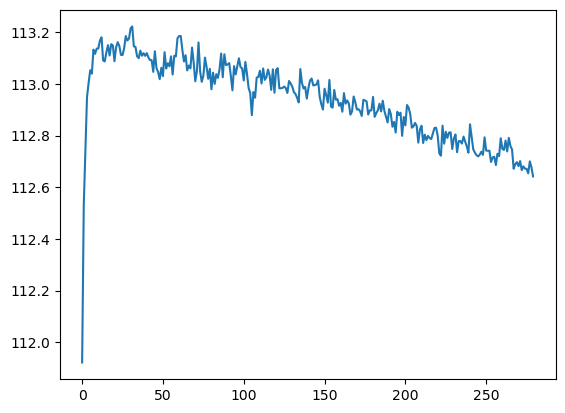

In [4]:
import matplotlib.pyplot as plt 
plt.plot(box_A0)

In [15]:
def get_coords(filename, atom):
    found = False
    with open(filename, "r") as file:
        total_lines = sum(1 for _ in file)
        file.seek(0)  # Reset the file pointer to the beginning
        progress_bar = tqdm(total=total_lines, desc="Processing")
    
        coords = []
        for line in file:
            progress_bar.update(1)  # Update the progress bar
            if atom in line:
                found = True
            elif found:
                coords.append(np.asarray(line.split()).astype(float))  # or do something else with the line
                found = False
        progress_bar.close()
    return coords

In [16]:
atom_labels = ['Li1+','Nb5+','O2-']

coords_dict = {}

for atom in atom_labels:
    print(f"Now pulling {atom}.")
    coords_dict[atom] = get_coords("B0/HISTORY", atom)

Now pulling Li1+.


Processing: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 55836482/55836482 [00:39<00:00, 1412406.25it/s]


Now pulling Nb5+.


Processing: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 55836482/55836482 [00:39<00:00, 1420906.14it/s]


Now pulling O2-.


Processing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 55836482/55836482 [01:15<00:00, 736683.63it/s]


In [25]:
NAT = {}
for key, value in coords_dict.items():
    print(f"The length of {key} is: {int(len(value)/snaps_A0)}")
    NAT[key] = int(len(value)/snaps_A0)
print(NAT)

The length of Li1+ is: 19441
The length of Nb5+ is: 19545
The length of O2- is: 60720
{'Li1+': 19441, 'Nb5+': 19545, 'O2-': 60720}


In [40]:
MSD_dict = {}
for key, value in coords_dict.items():
    MSD_dict[key] = []
    value_arr = np.array(value)
    ref = value_arr[:NAT[key],:]
    for ind in range(snaps_A0):
        inst = value_arr[ind*NAT[key]:(ind+1)*NAT[key], :]
    
        dis = periodic_distance(inst, ref, box_A0[ind])
        MSD_dict[key].append(np.mean(dis))

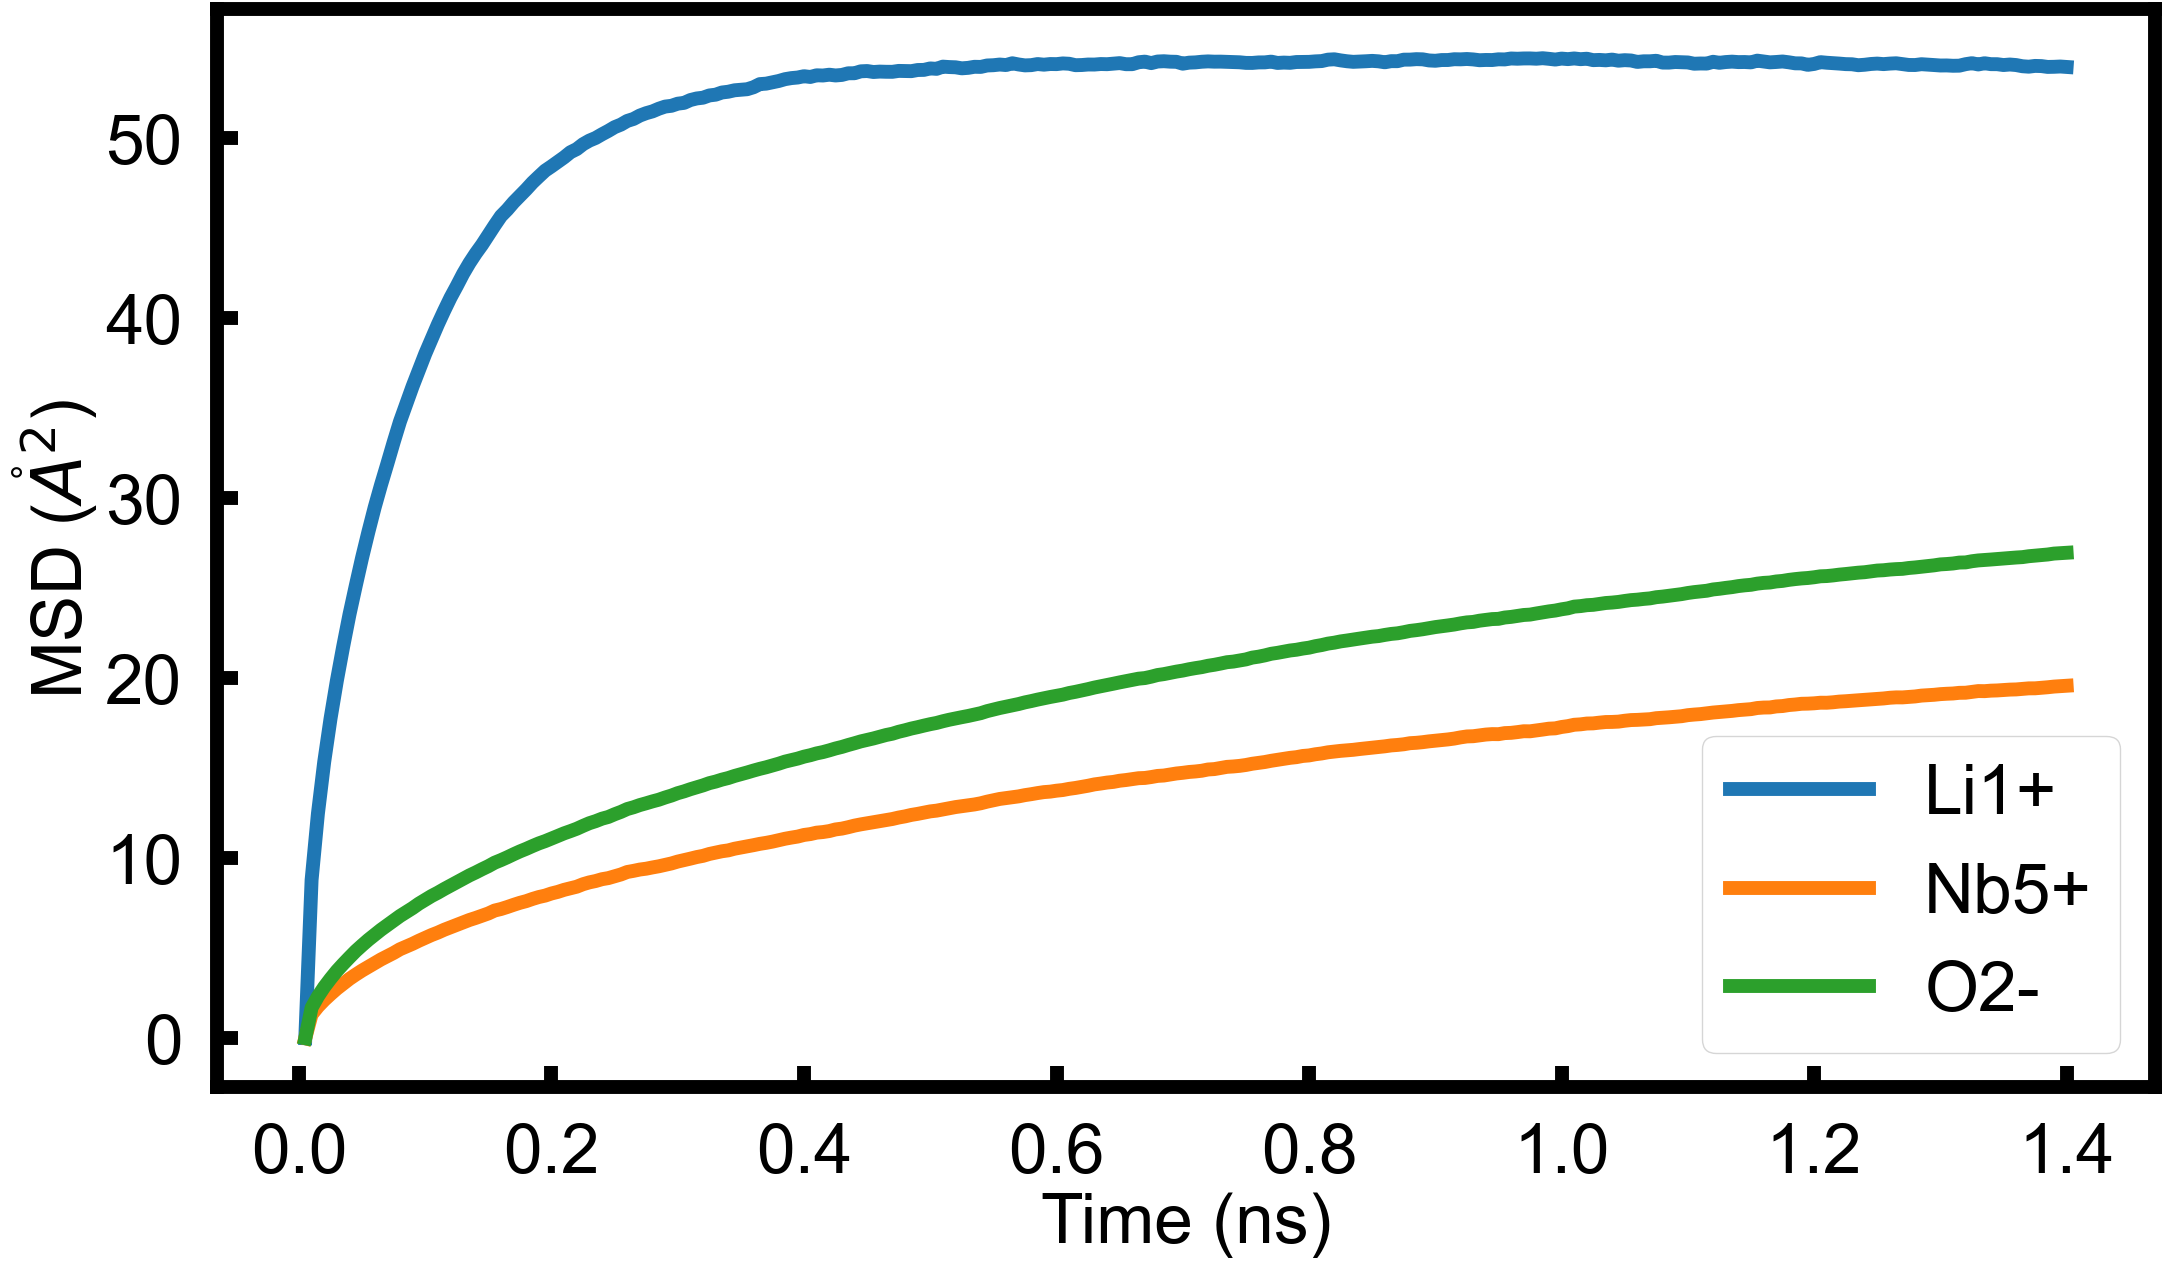

In [43]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 50
plt.rcParams['axes.labelsize'] = 50
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.titlesize'] = 75
plt.rcParams['axes.titleweight']='normal'
plt.rcParams['xtick.labelsize'] =50
plt.rcParams['ytick.labelsize'] =50
plt.rcParams['lines.linewidth']=10.0
plt.rcParams['figure.figsize'] = 25,14
plt.rcParams['lines.markersize']=30.0
plt.rcParams['axes.linewidth'] =10

plt.rcParams['xtick.major.size']=15
plt.rcParams['xtick.direction']= 'in'
plt.rcParams['xtick.major.width']=10.0

plt.rcParams['ytick.major.size']=15
plt.rcParams['ytick.direction']= 'in'
plt.rcParams['ytick.major.width']=10.0

plt.rcParams['xtick.major.pad']='25'
plt.rcParams['ytick.major.pad']='25'

for key, value in MSD_dict.items():
    plt.plot([((i+1)*5)/1000 for i in range(snaps_A0)], value, label=key)
plt.legend()
plt.xlabel("Time (ns)")
plt.ylabel("MSD ($\mathring{A}^2$)")
plt.savefig("MSD_atoms_20A.pdf", bbox_inches='tight', dpi=300)
plt.show()